## MLP + peak/valley classification
Extract heartbeats from raw dataset and trains an MLP for classification:
- Extract all usable heartbeats of fixed length from the raw data
- Uses the peak/valley algorithm to extract N peak amplitudes
- Trains an MLP network on the selected peaks

In [158]:
# Importing packages
import copy
import datetime
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import signal
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras import initializers
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import wfdb
import os
import tensorflow as tf
warnings.filterwarnings('ignore')

In [159]:
### PARAMETERS TO SET ###

# Balance the weight of the different classes of the (unbalanced) dataset
CUSTOM_WEIGHTS = True

# Parameters for heartbeat extraction
# Number of samples to consider as the length of an heartbeat
HEARTBEAT_LENGTH = 400
# Number of random points to extract from heartbeat
POINTS_LENGTH = 32

# Parameters for float to integer conversion
# 16bits max and min values
INT_RANGE = 65536
INT_LOW = -32768
INT_HIGH = 32767
# Wether to convert down to 8bit or stay at 16bit
CONV_8BIT = True
print("Range: "+str(INT_RANGE)+"   MIN: "+str(INT_LOW)+"   MAX:"+str(INT_HIGH))

# Parameters for saving files
# Confusion matrix img is saved in LOG_DIR
# Model is stored in MODEL_PATH_BASE with name MODEL_NAME_BASE plus two digits
LOG_DIR = "logs/mlp_only/"
MODEL_NAME_BASE = 'mlp_only_'
MODEL_PATH_BASE = 'models/mlp_only/'

Range: 65536   MIN: -32768   MAX:32767


In [160]:
# Parameters for determinism
KERAS_SEED = 1234509876
keras.utils.set_random_seed(KERAS_SEED)
tf.config.experimental.enable_op_determinism()

In [161]:
### Extract data from files
mitdb_list = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]

if CONV_8BIT:
    v_dataset_data = np.empty((1,HEARTBEAT_LENGTH), dtype=np.int8)
else:
    v_dataset_data = np.empty((1,HEARTBEAT_LENGTH), dtype=np.int16)

# Float dataset
v_dataset_data = np.empty((1,HEARTBEAT_LENGTH), dtype=float)
v_dataset_categ = np.empty(1, dtype=str)

v_data_min = 10.0
v_data_max = -10.0

for element in mitdb_list:
    record = wfdb.rdrecord('src/mitdb/' + str(element))
    v_data_min = np.min(record.p_signal) if np.min(record.p_signal) < v_data_min else v_data_min
    v_data_max = np.max(record.p_signal) if np.max(record.p_signal) > v_data_max else v_data_max

v_data_abs_max = np.max(np.abs([v_data_min, v_data_max]))

print("MAX: " + str(v_data_max) + "   MIN: " + str(v_data_min))
print("ABS MAX: " +str(v_data_abs_max))

for element in mitdb_list:


    print("##########")
    print("Current record: " + str(element))

    # Load all samples
    record = wfdb.rdrecord('src/mitdb/' + str(element))
    annotation = wfdb.rdann('src/mitdb/'+str(element), 'atr')

    # Convert annotations to useful ones
    # Read symbols and substitute them
    # Classes:  'N': Normal beat
    #           'S': Supraventricular premature
    #           'V': Premature ventricular contraction
    #           'F': Fusion of ventricular and normal beat
    #           'Q': Unclassifiable
    #
    # CLASSIFICATION
    # Based on the paper "A deep convolutional neural network model to classify heartbeats"
    symbol_dict = { 'N':'N', 'L':'N', 'R':'N', 'e':'N', 'j':'N',
                    'S':'S', 'A':'S', 'a':'S', 'J':'S',
                    'V':'V', 'E':'V',
                    'F':'F',
                    'Q':'Q', '/':'Q', 'f':'Q'}
    raw_ann_symbol = annotation.symbol.copy()
    raw_ann_sample = annotation.sample.copy()
    #raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else key for key in raw_ann_symbol]
    raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else 'Z' for key in raw_ann_symbol]

    # Delete non beat annotations
    if 'Z' in raw_ann_symbol:
        i_del = [i for i, x in enumerate(raw_ann_symbol) if x == 'Z']
        raw_ann_sample = np.delete(raw_ann_sample, i_del)
        raw_ann_symbol = np.delete(raw_ann_symbol, i_del)

    # Extract ECG data array
    v_data_f = record.p_signal
    v_data_f = v_data_f[:,0]

    # Convert data from float to uint16
    #v_data = np.zeros_like(v_data_f, dtype=np.int16)
    #for i in range(0, len(v_data_f)):
    #    # Offset and scale
    #    #v_data[i] = ((v_data_f[i]-v_data_min)/(v_data_max - v_data_min))*(INT_RANGE)+(INT_LOW)
    #    # Scale only
    #    v_data[i] = np.int16((v_data_f[i])/(v_data_abs_max)*(INT_HIGH))
    #    if CONV_8BIT:
    #        v_data[i] = np.int8((v_data[i] >> 8) & 0xFF)

    # If using float instead of int
    #v_data = v_data_f/v_data_abs_max*INT_HIGH
    v_data = v_data_f

    print(v_data_f)
    print(v_data)

    # Define time array (Fs:360Hz)
    v_time = np.arange(0, HEARTBEAT_LENGTH, 1, dtype=int)

    # Zeros array for x-axis
    axis_x = np.zeros_like(v_time)

    # Delete annotations for beats too close to the beginning or ending of signal
    raw_ann_symbol = raw_ann_symbol[(raw_ann_sample > (HEARTBEAT_LENGTH/2+1)) & (raw_ann_sample < (len(v_data)-(HEARTBEAT_LENGTH/2+1)))]
    raw_ann_sample = raw_ann_sample[(raw_ann_sample > (HEARTBEAT_LENGTH/2+1)) & (raw_ann_sample < (len(v_data)-(HEARTBEAT_LENGTH/2+1)))]

    print(raw_ann_symbol)
    print(raw_ann_sample)
    print(len(raw_ann_symbol))
    print(len(raw_ann_sample))
    
    # Divide signal in single heartbeats
    v_total_data = np.zeros(shape=(len(raw_ann_symbol),HEARTBEAT_LENGTH))
    v_total_categ = np.empty(len(raw_ann_symbol), dtype=str)
    for i in range(0, len(v_total_data)-1):
        v_total_data[i,:] = v_data[(raw_ann_sample[i] - int(HEARTBEAT_LENGTH/2)) : (raw_ann_sample[i] + int(HEARTBEAT_LENGTH/2))]
        v_total_categ[i] = raw_ann_symbol[i]
        #print(v_total_data[i,:])

    # Delete empty data
    v_total_data = v_total_data[v_total_categ != '']
    v_total_categ = v_total_categ[v_total_categ != '']

    # Copy results to dataset variables
    v_dataset_data = np.append(v_dataset_data, v_total_data, axis=0)
    v_dataset_categ = np.append(v_dataset_categ, v_total_categ)

# Delete first element (empty)
v_dataset_data = v_dataset_data[1:,:]
v_dataset_categ = v_dataset_categ[1:]

print(v_dataset_categ)
print(v_dataset_data)
    

MAX: 5.115   MIN: -5.12
ABS MAX: 5.12
##########
Current record: 100
[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
['N' 'N' 'N' ... 'N' 'N' 'N']
[   370    662    946 ... 649232 649484 649734]
2271
2271
##########
Current record: 101
[-0.345 -0.345 -0.345 ... -0.295 -0.29   0.   ]
[-0.345 -0.345 -0.345 ... -0.295 -0.29   0.   ]
['N' 'N' 'N' ... 'N' 'N' 'N']
[   396    711   1032 ... 649004 649372 649751]
1864
1864
##########
Current record: 102
[-0.2   -0.2   -0.2   ... -0.17  -0.195  0.   ]
[-0.2   -0.2   -0.2   ... -0.17  -0.195  0.   ]
['Q' 'Q' 'Q' ... 'Q' 'Q' 'Q']
[   410    697    989 ... 648931 649244 649553]
2185
2185
##########
Current record: 103
[-0.375 -0.375 -0.375 ... -0.235 -0.245  0.   ]
[-0.375 -0.375 -0.375 ... -0.235 -0.245  0.   ]
['N' 'N' 'N' ... 'N' 'N' 'N']
[   265    575    876 ... 648872 649195 649534]
2083
2083
##########
Current record: 104
[-0.15  -0.15  -0.15  ... -0.065 -0.06   0.   ]
[-0.15  -0.15  -0.15  .

In [162]:
# Extract N random numbers from heartbeat
random_indices = np.random.choice(HEARTBEAT_LENGTH, size=POINTS_LENGTH, replace=False)
random_indices = np.sort(random_indices)
v_dataset_data_rand = [arr[random_indices] for arr in v_dataset_data]
#print(v_dataset_data)
#print(random_indices)

In [178]:
# Apply peak/valley algorith to all heartbeats
# Identify potential peaks
# Compare 3 signal samples S0, S1, S2
# Peak if:  S1>S0 and S1>S2
#           S1<S0 and S1<S2

FREQ_SAMPLE = 360

DELTA_PEAK = 0.04
#DELTA_TIME = 75/FREQ_SAMPLE     # Number of samples / Sampling frequency
DELTA_TIME = 15

v_peaks_data = np.zeros_like(v_dataset_data)
v_peaks_time = np.zeros_like(v_dataset_data, dtype=int)

print(v_peaks_data.shape)

for n in range(len(v_dataset_data)):
    j = 0
    # Walk through all samples
    for i in range(1, len(v_dataset_data[n])-1):
        # Identify peak
        if  ((v_dataset_data[n][i] >= v_dataset_data[n][i-1]) and (v_dataset_data[n][i] > v_dataset_data[n][i+1])) or \
            ((v_dataset_data[n][i] <= v_dataset_data[n][i-1]) and (v_dataset_data[n][i] < v_dataset_data[n][i+1])):
            # Check if peak value big enough
            if  (abs(v_dataset_data[n][i] - v_peaks_data[n][j-1]) > DELTA_PEAK) or \
                (abs(v_time[i] - v_peaks_time[n][j-1]) > DELTA_TIME):
                v_peaks_data[n][j] = v_dataset_data[n][i]
                v_peaks_time[n][j] = v_time[i]
                j += 1
                

    #v_peaks_data = v_peaks_data[v_peaks_time != 0]
    #v_peaks_time = v_peaks_time[v_peaks_time != 0]

(109381, 400)


In [179]:
# Select useful peaks and valleys for training

low_time = np.zeros(shape=int(POINTS_LENGTH/2), dtype=int)
high_time = np.zeros(shape=int(POINTS_LENGTH/2), dtype=int)
points_time = np.zeros(shape=(len(v_peaks_time), POINTS_LENGTH), dtype=int)
points_data = np.zeros(shape=(len(v_peaks_time), POINTS_LENGTH))

for n in range(len(v_peaks_time)):
    #print("n: "+str(n))
    # Split array in half
    low_time_tmp = v_peaks_time[n][v_peaks_time[n] <= int(HEARTBEAT_LENGTH/2)]
    high_time_tmp = v_peaks_time[n][v_peaks_time[n] > int(HEARTBEAT_LENGTH/2)]

    low_time_tmp = low_time_tmp[low_time_tmp != 0]
    high_time_tmp = high_time_tmp[high_time_tmp != 0]
    #print("low_time_tmp1: "+str(low_time_tmp))

    # Select correct number of points from each half
    low_time_tmp = low_time_tmp[-int(POINTS_LENGTH/2):]
    high_time_tmp = high_time_tmp[:int(POINTS_LENGTH/2)]
    #print("low_time_tmp2: "+str(low_time_tmp))

    # Check if the correct number of points were selected
    if len(low_time_tmp) > 0:
        low_time[-len(low_time_tmp):] = low_time_tmp
    else:
        low_time = np.zeros(shape=int(POINTS_LENGTH/2), dtype=int)
    if len(high_time_tmp) > 0:
        high_time[:len(high_time_tmp):] = high_time_tmp
    else:
        high_time = np.zeros(shape=int(POINTS_LENGTH/2), dtype=int)

    # Copy points to final arrays
    points_time[n] = np.append(low_time, high_time)
    points_data[n] = v_dataset_data[n][points_time[n]]

    
    #print("points_time[n]: "+str(points_time[n]))
    #print("points_data[n]: "+str(points_data[n]))




In [180]:
# Backup dataset to other variable

### All points
#v_dataset_data_bk = np.copy(v_dataset_data)
### Random selection of points
#v_dataset_data_bk = np.copy(v_dataset_data_rand)
### Peak/valley
v_dataset_data_bk = np.copy(points_data)


v_dataset_categ_bk = np.copy(v_dataset_categ)

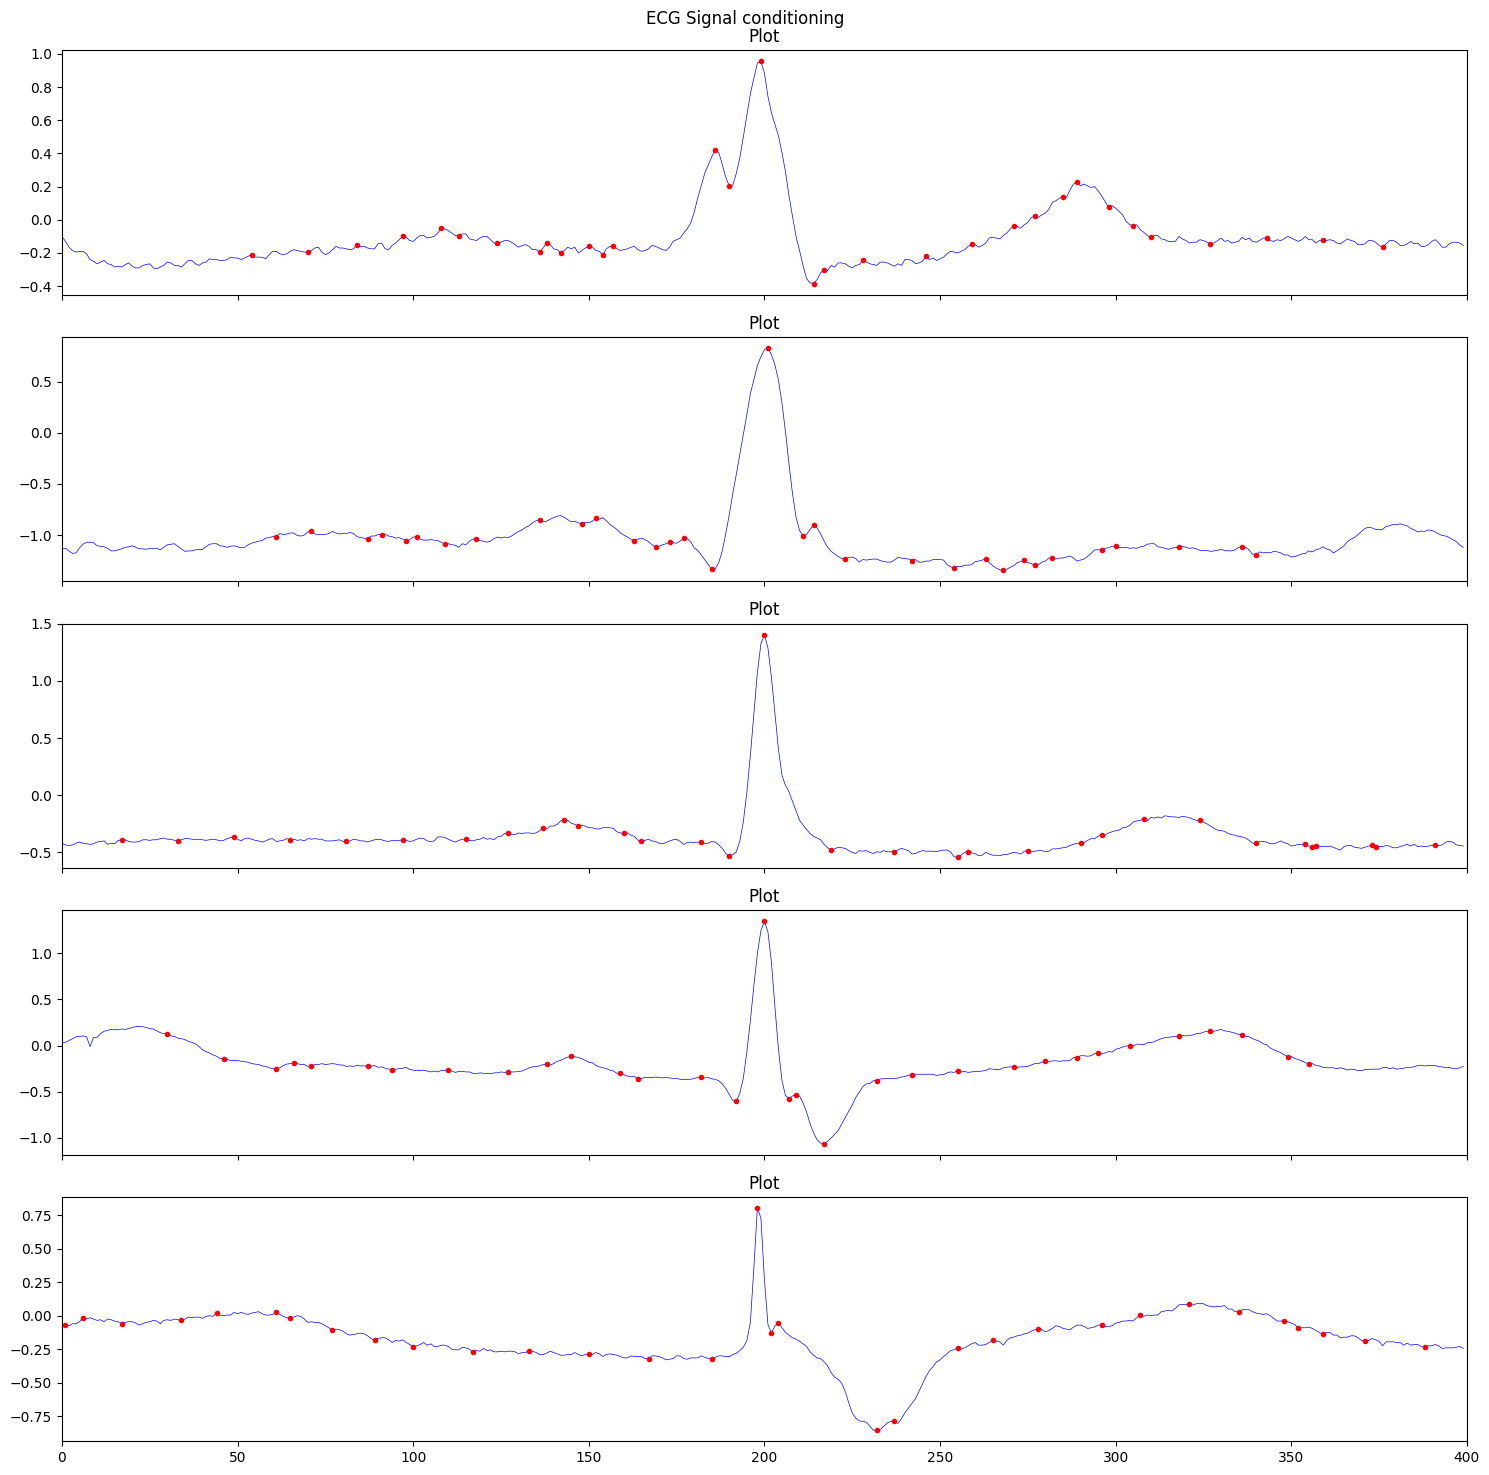

In [181]:
# Plotting window
X_MIN = 0
X_MAX = 400
N_ROW = 5
N_COL = 1
PLOT_LOW = INT_LOW
PLOT_HIGH = INT_HIGH

if CONV_8BIT:
    PLOT_LOW = -128
    PLOT_HIGH = 127

n = 0
# Create plots
fig, axs = plt.subplots(N_ROW, N_COL, sharex=True)
fig.set_size_inches(15, 3*N_ROW)
fig.suptitle("ECG Signal conditioning")
axs[n].set_xlim(X_MIN, X_MAX)

for n in range(0, N_ROW):
    # First plot
    rand = random.randint(0, points_time.shape[0])
    axs[n].title.set_text('Plot')
    axs[n].plot(v_dataset_data[rand], 'b', label="raw data", linewidth=0.5)
    axs[n].plot(points_time[rand], points_data[rand], 'r.', label="raw data", linewidth=0.5)
    #n += 1



# First plot
#axs[n].title.set_text('Plot')
#axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
#axs[n].plot(v_time, v_dataset_data[n], 'b', label="raw data", linewidth=0.5)
#axs[n].legend()
#n += 1

# First plot
#axs[n].title.set_text('Plot')
#axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
#axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
#axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
#axs[n].plot(v_peaks_P_time, v_peaks_P_data, 'bo', label="P peaks", linewidth=0.5)
#axs[n].plot(v_peaks_T_time, v_peaks_T_data, 'ro', label="T peaks", linewidth=0.5)
#axs[n].legend()
#n += 1

plt.tight_layout()
plt.show()

In [182]:
#stop

In [183]:
# Copy from backup data
dataset_categ = np.copy(v_dataset_categ_bk)
dataset_data = np.copy(v_dataset_data_bk)

# Convert symbols to numbers
category_dict = {   'N':0,
                    'S':1,
                    'V':2,
                    'F':3,
                    'Q':4}
dataset_categ = [category_dict[key] if key in category_dict else 'Z' for key in dataset_categ]

# Divide data into sets
DATA_SPLIT = 0.2
SEED = 1029384756
set_train, x_valid, target_train, y_valid = train_test_split(dataset_data, dataset_categ, test_size=DATA_SPLIT, random_state=SEED)
x_train, x_test, y_train, y_test = train_test_split(set_train, target_train, test_size=DATA_SPLIT, random_state=SEED)

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_valid=to_categorical(y_valid)

In [184]:
# Calculate cutom weights for training
tot_y_train = np.sum(y_train, axis=0)
tot_y_test = np.sum(y_test, axis=0)
tot_y_valid = np.sum(y_valid, axis=0)
tot_y_all = tot_y_train + tot_y_test + tot_y_valid

print(tot_y_train)
print(tot_y_test)
print(tot_y_valid)
print(tot_y_all)

max_class = np.max(tot_y_train)
#max_class = np.sum(tot_y_train)

custom_weights = {  0: int(max_class/tot_y_train[0]),
                    1: int(max_class/tot_y_train[1]),
                    2: int(max_class/tot_y_train[2]),
                    3: int(max_class/tot_y_train[3]),
                    4: int(max_class/tot_y_train[4])}

print(custom_weights)

[57974.  1776.  4643.   520.  5090.]
[14483.   485.  1093.   118.  1322.]
[18075.   517.  1499.   164.  1622.]
[90532.  2778.  7235.   802.  8034.]
{0: 1, 1: 32, 2: 12, 3: 111, 4: 11}


In [185]:
# Define NN structure
NEURONS = 20
LEARNING_RATE = 0.0001
model = Sequential([
    Input(shape=((x_train[0].shape[0],1)), name='inputs_nn'),
    Flatten(),    
    # Custom initial weights for deterministic behavior
    Dense(NEURONS, activation='relu', name="dense_1", kernel_initializer=initializers.GlorotUniform(seed=KERAS_SEED), bias_initializer='zeros'),
    Dense(5, activation='softmax', name='main_output', kernel_initializer=initializers.GlorotUniform(seed=KERAS_SEED), bias_initializer='zeros') 
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 765 (2.99 KB)

 Trainable params: 765 (2.99 KB)

 Non-trainable params: 0 (0.00 B)

In [186]:
# Training parameters
EPOCH_NUM = 150
BATCH_SIZE = 64

# Train model
if (CUSTOM_WEIGHTS):
    history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid), class_weight=custom_weights)
else:
    history=model.fit(x_train, y_train, epochs=EPOCH_NUM, batch_size=BATCH_SIZE, validation_data=(x_valid,y_valid))


Epoch 1/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6882 - loss: 6.7212 - val_accuracy: 0.5694 - val_loss: 1.3567
Epoch 2/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5545 - loss: 5.9581 - val_accuracy: 0.4981 - val_loss: 1.3326
Epoch 3/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4866 - loss: 5.4795 - val_accuracy: 0.4310 - val_loss: 1.3098
Epoch 4/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4233 - loss: 5.1053 - val_accuracy: 0.3929 - val_loss: 1.2869
Epoch 5/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3954 - loss: 4.8049 - val_accuracy: 0.3823 - val_loss: 1.2635
Epoch 6/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3886 - loss: 4.5623 - val_accuracy: 0.3832 - val_loss: 1.2389
Epoch 7/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3903 - loss: 4.3631 - val_accuracy: 0.3860 - val_loss: 1.2170
Epoch 8/150
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3923 - loss: 4

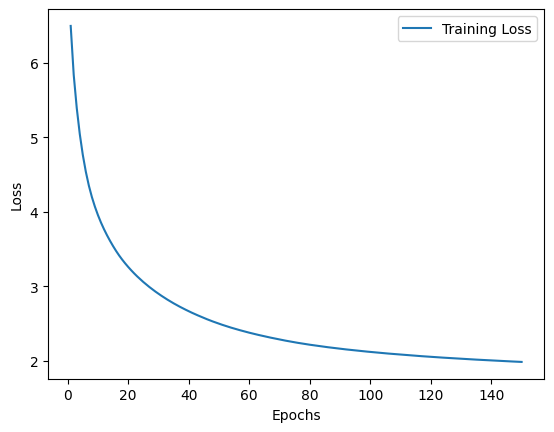

In [187]:
# Training Loss plot
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0, 10)
plt.legend()

plt.show()

In [188]:
# Prediction confusion matrix
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test_pred = np.argmax(y_test, axis=1)


# Create confusion matrix and normalize it over predicted (columns)
#result = confusion_matrix(y_test_pred, y_prediction , normalize='pred')
result = confusion_matrix(y_test_pred, y_prediction , normalize='true')
#result = confusion_matrix(y_test_pred, y_prediction , normalize='all')
#result = confusion_matrix(y_test_pred, y_prediction)
classes = [0,1,2,3,4]
result_norm = np.around(result, 3)
#result_norm = result
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step
Confusion matrix
       0      1      2      3      4
0  0.752  0.138  0.026  0.064  0.020
1  0.144  0.784  0.023  0.019  0.031
2  0.038  0.044  0.823  0.061  0.034
3  0.076  0.017  0.110  0.797  0.000
4  0.041  0.011  0.017  0.014  0.918

Average accuracy
0.8144727158547761


In [189]:
# Print detailed results
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(y_test_pred, y_prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      0.75      0.85     14483
     class 1       0.16      0.78      0.26       485
     class 2       0.68      0.82      0.74      1093
     class 3       0.08      0.80      0.15       118
     class 4       0.78      0.92      0.84      1322

    accuracy                           0.77     17501
   macro avg       0.54      0.81      0.57     17501
weighted avg       0.92      0.77      0.82     17501



In [190]:
model_num = 0
#while os.path.exists(MODEL_PATH_BASE + MODEL_NAME_BASE + "%s.keras" % f"{model_num:02}"):
#    model_num += 1
log_dir = LOG_DIR
#model_name = MODEL_NAME_BASE+ str(f"{model_num:02}")
model_name = MODEL_NAME_BASE+ str(f"{NEURONS:02}")
model_path = MODEL_PATH_BASE + model_name + '.keras'
model.name = model_name
#model.save(model_path)

In [191]:
model_name = "mlp_beat"+str(f"{HEARTBEAT_LENGTH:03}")+"_rand"+str(f"{POINTS_LENGTH:03}")+"_n"+str(f"{NEURONS:02}")

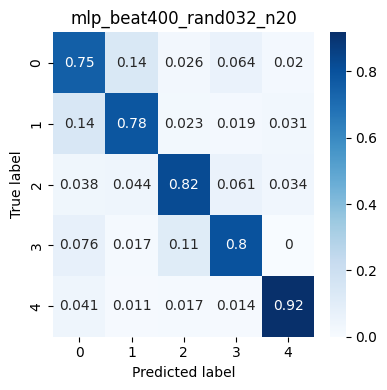

In [192]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
#plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()